# **Retraining only using informative features**

From the feature importance analysis, it emerged that most of the features contribute very little to the model predicting decisions. It would be great to try and train the same models by only using features relevant to them.\
Even if we don't really expect the models to perform better, simply because it learnt to ignore the less relevant featres, we could obtain smaller models, with less data needed. Overall, a faster computation might be achieved.

## **Data and Model Import**

In [ ]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from utils import *


datasets_folder = './datasets'
models_folder = './models'
figsize = (20,4)
verbosity = 0

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

d:\GitHub\AII-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = list(pollution_data.keys())
agents = list(set(agent for station in stations for agent in pollution_data[station].keys()))

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


## **New training and test sets**

We list all the features that doesnt seem to help the model or that are not really coherent. The order of the following features is extracted from the previous [notebook](./7-feature-importance.ipynb).

In [4]:
shap_feature_importance = {
'GIARDINI MARGHERITA': {
       'NO2': ['Traffic_value', 'W_VEC_DIR', 'W_SCAL_INT', 'RAD', 'TAVG', 'RHAVG', 'hour_sin', 'hour_cos', 'LEAFW', 'month_rbf_8', 'month_rbf_9', 'month_rbf_5', 'month_rbf_4', 'day_cos', 'month_rbf_7', 'month_rbf_1', 'day_sin', 'month_rbf_6', 'month_rbf_11', 'month_rbf_10', 'month_rbf_12', 'month_rbf_2', 'month_rbf_3', 'PREC' ],
       'O3': ['TAVG', 'RHAVG', 'RAD', 'W_SCAL_INT', 'W_VEC_DIR', 'Traffic_value', 'hour_cos', 'day_sin', 'day_cos', 'hour_sin', 'month_rbf_5', 'LEAFW', 'month_rbf_7', 'month_rbf_8', 'month_rbf_2', 'month_rbf_11', 'month_rbf_6', 'month_rbf_3', 'month_rbf_1', 'month_rbf_10', 'month_rbf_4', 'month_rbf_9', 'PREC', 'month_rbf_12' ],
       'PM10': ['month_rbf_12', 'W_SCAL_INT', 'month_rbf_6', 'month_rbf_1', 'RHAVG_MIN', 'PREC', 'TAVG', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG', 'month_rbf_2', 'LEAFW', 'W_VEC_DIR', 'month_rbf_5', 'day_sin', 'RAD', 'RHAVG_MAX', 'day_cos', 'month_rbf_7', 'month_rbf_3', 'Traffic_6-8', 'month_rbf_11', 'Traffic_15-17', 'Traffic_12-14', 'month_rbf_4', 'Traffic_9-11', 'Traffic_18-20', 'Traffic_0-2', 'Traffic_21-0', 'month_rbf_10', 'Traffic_3-5', 'month_rbf_9', 'month_rbf_8' ],
       'PM2.5': ['W_SCAL_INT', 'TAVG_MIN', 'RHAVG_MIN', 'TAVG_MAX', 'LEAFW', 'TAVG', 'RHAVG', 'RHAVG_MAX', 'day_sin', 'PREC', 'month_rbf_5', 'month_rbf_7', 'day_cos', 'Traffic_18-20', 'month_rbf_8', 'RAD', 'month_rbf_9', 'month_rbf_2', 'month_rbf_6', 'W_VEC_DIR', 'Traffic_6-8', 'month_rbf_4', 'Traffic_0-2', 'Traffic_9-11', 'Traffic_21-0', 'Traffic_15-17', 'Traffic_12-14', 'Traffic_3-5', 'month_rbf_1', 'month_rbf_3', 'month_rbf_12', 'month_rbf_11', 'month_rbf_10' ],
    },
'PORTA SAN FELICE': {
       'C6H6': ['Traffic_value', 'RHAVG', 'W_SCAL_INT', 'month_rbf_8', 'W_VEC_DIR', 'hour_cos', 'TAVG', 'month_rbf_9', 'hour_sin', 'RAD', 'month_rbf_7', 'month_rbf_6', 'month_rbf_1', 'day_sin', 'month_rbf_4', 'day_cos', 'month_rbf_5', 'LEAFW', 'month_rbf_11', 'month_rbf_12', 'month_rbf_3', 'month_rbf_10', 'PREC', 'month_rbf_2' ],
       'CO': ['Traffic_value', 'month_rbf_8', 'W_SCAL_INT', 'RHAVG', 'W_VEC_DIR', 'hour_cos', 'month_rbf_9', 'hour_sin', 'RAD', 'TAVG', 'month_rbf_7', 'month_rbf_6', 'day_sin', 'month_rbf_1', 'day_cos', 'month_rbf_5', 'month_rbf_4', 'month_rbf_12', 'LEAFW', 'month_rbf_11', 'month_rbf_3', 'month_rbf_10', 'PREC', 'month_rbf_2' ],
       'NO2': ['W_VEC_DIR', 'hour_sin', 'month_rbf_5', 'month_rbf_10', 'W_SCAL_INT', 'day_cos', 'month_rbf_7', 'RHAVG', 'day_sin', 'Traffic_value', 'month_rbf_9', 'month_rbf_1', 'month_rbf_2', 'TAVG', 'RAD', 'month_rbf_4', 'month_rbf_11', 'month_rbf_3', 'month_rbf_6', 'month_rbf_8', 'month_rbf_12', 'hour_cos', 'PREC', 'LEAFW' ],
       'PM10': ['W_SCAL_INT', 'LEAFW', 'TAVG_MIN', 'RHAVG_MIN', 'RAD', 'month_rbf_2', 'TAVG_MAX', 'RHAVG', 'TAVG', 'PREC', 'W_VEC_DIR', 'day_sin', 'Traffic_6-8', 'RHAVG_MAX', 'Traffic_15-17', 'day_cos', 'Traffic_12-14', 'month_rbf_1', 'Traffic_21-0', 'month_rbf_3', 'Traffic_3-5', 'Traffic_18-20', 'Traffic_0-2', 'Traffic_9-11', 'month_rbf_8', 'month_rbf_11', 'month_rbf_5', 'month_rbf_9', 'month_rbf_6', 'month_rbf_4', 'month_rbf_10', 'month_rbf_7', 'month_rbf_12' ],
       'PM2.5': ['W_SCAL_INT', 'LEAFW', 'TAVG_MIN', 'RHAVG_MIN', 'TAVG', 'RAD', 'RHAVG_MAX', 'PREC', 'RHAVG', 'day_sin', 'TAVG_MAX', 'day_cos', 'month_rbf_2', 'month_rbf_1', 'W_VEC_DIR', 'Traffic_0-2', 'Traffic_18-20', 'month_rbf_4', 'Traffic_21-0', 'Traffic_6-8', 'Traffic_12-14', 'month_rbf_5', 'Traffic_15-17', 'Traffic_9-11', 'month_rbf_12', 'month_rbf_3', 'Traffic_3-5', 'month_rbf_8', 'month_rbf_6', 'month_rbf_11', 'month_rbf_10', 'month_rbf_7', 'month_rbf_9' ],
    },
'VIA CHIARINI': {
       'NO2': ['Traffic_value', 'hour_cos', 'TAVG', 'hour_sin', 'W_SCAL_INT', 'RHAVG', 'W_VEC_DIR', 'month_rbf_1', 'month_rbf_2', 'month_rbf_4', 'day_cos', 'RAD', 'month_rbf_6', 'month_rbf_12', 'month_rbf_7', 'month_rbf_8', 'day_sin', 'month_rbf_5', 'month_rbf_11', 'month_rbf_3', 'LEAFW', 'month_rbf_9', 'month_rbf_10', 'PREC' ],
       'O3': ['TAVG', 'RAD', 'RHAVG', 'W_VEC_DIR', 'W_SCAL_INT', 'Traffic_value', 'hour_cos', 'day_sin', 'hour_sin', 'LEAFW', 'month_rbf_5', 'month_rbf_4', 'month_rbf_11', 'month_rbf_3', 'day_cos', 'month_rbf_8', 'month_rbf_1', 'month_rbf_6', 'month_rbf_2', 'month_rbf_10', 'month_rbf_7', 'month_rbf_12', 'month_rbf_9', 'PREC' ],
       'PM10': ['W_SCAL_INT', 'month_rbf_12', 'PREC', 'month_rbf_1', 'month_rbf_6', 'TAVG_MIN', 'TAVG', 'TAVG_MAX', 'month_rbf_2', 'W_VEC_DIR', 'RHAVG_MIN', 'day_sin', 'month_rbf_5', 'LEAFW', 'RAD', 'month_rbf_7', 'RHAVG', 'Traffic_3-5', 'Traffic_6-8', 'Traffic_12-14', 'Traffic_18-20', 'RHAVG_MAX', 'day_cos', 'Traffic_21-0', 'Traffic_15-17', 'month_rbf_11', 'month_rbf_3', 'Traffic_9-11', 'Traffic_0-2', 'month_rbf_9', 'month_rbf_10', 'month_rbf_4', 'month_rbf_8' ],
    },
}

In [5]:
training_sets_informative = {}
test_sets_informative = {}
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'
num_keep=10

for station in stations:
    training_sets_informative[station] = {}
    test_sets_informative[station] = {}
    for agent in station_data[station].keys():
        training_sets_informative[station][agent] = {}
        test_sets_informative[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent].drop(columns=shap_feature_importance[station][agent][num_keep:]), train_split_date, y=target)

        training_sets_informative[station][agent]['x'] = x_train
        training_sets_informative[station][agent]['y'] = y_train
        test_sets_informative[station][agent]['x'] = x_test
        test_sets_informative[station][agent]['y'] = y_test

## **Training**

We can import the same models used for the first training, changing the input size to match the number of features that we want to keep.

In [6]:
models_informative = get_models(num_keep, num_keep)

And we then train the models once again.

In [7]:
agents_predictions_informative = train_agents(models_informative, training_sets_informative, test_sets_informative)

Predicting NO2 in GIARDINI MARGHERITA using Conv1D 2...
Predicting O3 in GIARDINI MARGHERITA using Conv1D 3...
Predicting PM10 in GIARDINI MARGHERITA using Random Forest Regressor 2...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
Predicting C6H6 in PORTA SAN FELICE using Conv1D...
Predicting CO in PORTA SAN FELICE using XGB Regressor...
Predicting NO2 in PORTA SAN FELICE using LSTM-masked...
Predicting PM10 in PORTA SAN FELICE using Feed Forward NN BatchNorm...
Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN BatchNorm...
Predicting NO2 in VIA CHIARINI using Feed Forward NN 2...
Predicting O3 in VIA CHIARINI using Conv1D 2...
Predicting PM10 in VIA CHIARINI using Random Forest Regressor 2...


We can extract, as earlier, the metric results and compare them with the older ones.

In [8]:
metrics_predictions_informative = training_results_to_dataframe(agents_predictions_informative, multiple_models=False)
metrics_predictions_informative

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,0.534026,0.594961,0.352483,0.053982
1,GIARDINI MARGHERITA,O3,0.330635,0.877148,0.244296,0.033158
2,GIARDINI MARGHERITA,PM10,0.757030,0.365922,0.536460,0.089308
3,GIARDINI MARGHERITA,PM2.5,0.752029,0.439310,0.497928,0.081966
4,PORTA SAN FELICE,C6H6,0.554963,0.666786,0.349981,0.053491
5,PORTA SAN FELICE,CO,0.658416,0.585908,0.506259,0.083080
6,PORTA SAN FELICE,NO2,1.002697,-0.863835,0.843657,0.149606
7,PORTA SAN FELICE,PM10,0.766072,0.419641,0.512398,0.084865
8,PORTA SAN FELICE,PM2.5,0.676725,0.556221,0.464183,0.074993
9,VIA CHIARINI,NO2,0.529872,0.544721,0.413185,0.064655


Apparently, some models benefit from the semplification and reduce the metric scores, while others don't change or, even, gets worse.

## **Air Quality Index**

In [9]:
agents_predictions_informative_original_dist = agents_predictions_informative.copy()
test_sets_informative_original_dist = test_sets_informative.copy()

We have to go back to the original distributions in order to compute the AQI.

In [10]:
for station in stations:
    for agent in agents_predictions_informative_original_dist[station]:
        test_sets_informative_original_dist[station][agent]['y'] = (test_sets_informative_original_dist[station][agent]['y'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']
        agents_predictions_informative_original_dist[station][agent]['predictions'] = (agents_predictions_informative_original_dist[station][agent]['predictions'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']

Station GIARDINI MARGHERITA Hourly


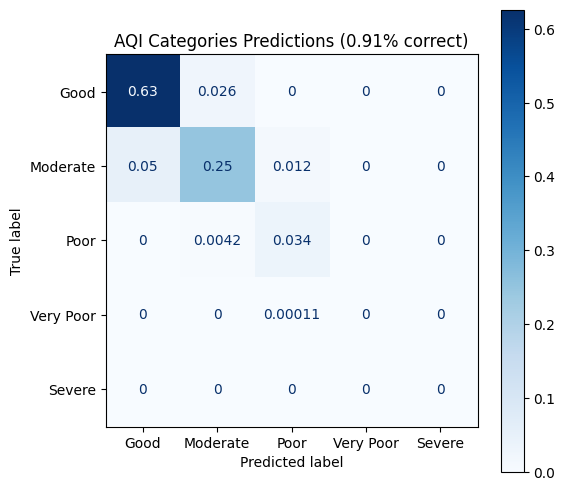

---------------------------------------------
> Absolute Mean AQI Difference: 7.34
> Positive Average AQI Difference: 6.69
> Negative Average AQI Difference: -7.98
> Percentage of Positive Differences: 49.76%
> Percentage of Negative Differences: 50.02%
> Percentage of Agent Values:
   - Same agent: 88.54
   - Different agents: 11.46
Station PORTA SAN FELICE Hourly


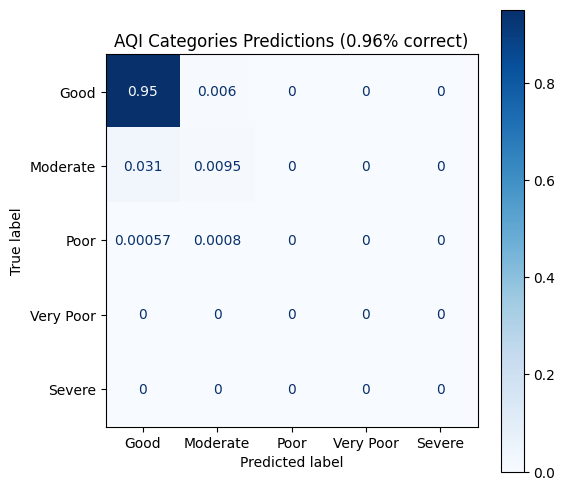

---------------------------------------------
> Absolute Mean AQI Difference: 6.43
> Positive Average AQI Difference: 6.08
> Negative Average AQI Difference: -7.09
> Percentage of Positive Differences: 65.37%
> Percentage of Negative Differences: 34.44%
> Percentage of Agent Values:
   - Same agent: 58.96
   - Different agents: 41.04
Station VIA CHIARINI Hourly


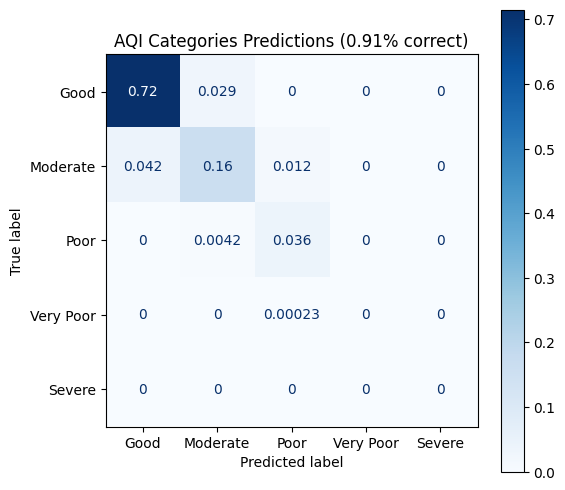

---------------------------------------------
> Absolute Mean AQI Difference: 7.10
> Positive Average AQI Difference: 6.91
> Negative Average AQI Difference: -7.31
> Percentage of Positive Differences: 53.29%
> Percentage of Negative Differences: 46.40%
> Percentage of Agent Values:
   - Same agent: 87.22
   - Different agents: 12.78
Station GIARDINI MARGHERITA Daily


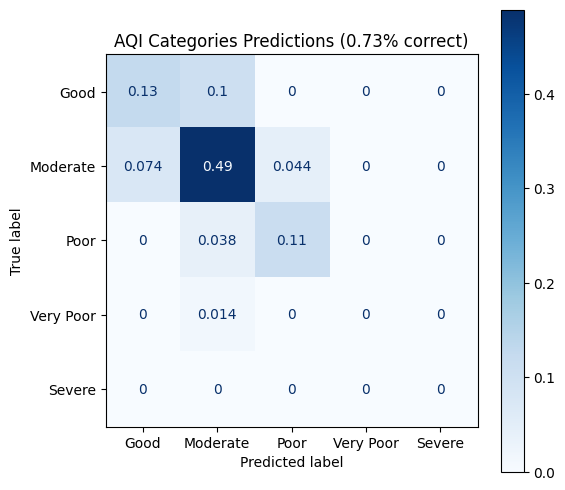

---------------------------------------------
> Absolute Mean AQI Difference: 13.35
> Positive Average AQI Difference: 11.67
> Negative Average AQI Difference: -15.28
> Percentage of Positive Differences: 53.55%
> Percentage of Negative Differences: 46.45%
> Percentage of Agent Values:
   - Same agent: 75.14
   - Different agents: 24.86
Station PORTA SAN FELICE Daily


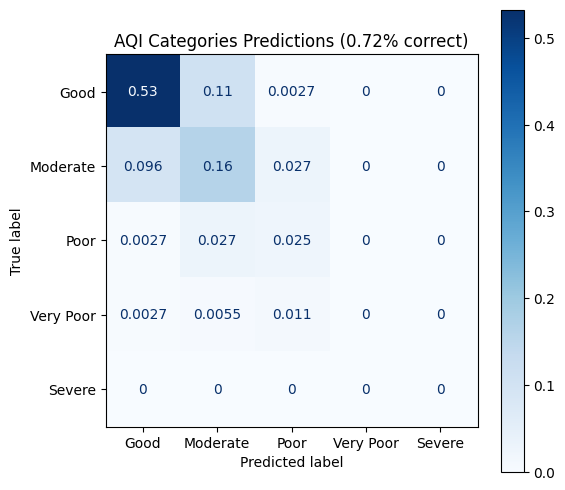

---------------------------------------------
> Absolute Mean AQI Difference: 15.40
> Positive Average AQI Difference: 15.03
> Negative Average AQI Difference: -15.85
> Percentage of Positive Differences: 54.92%
> Percentage of Negative Differences: 45.08%
> Percentage of Agent Values:
   - Same agent: 84.43
   - Different agents: 15.57
Station VIA CHIARINI Daily


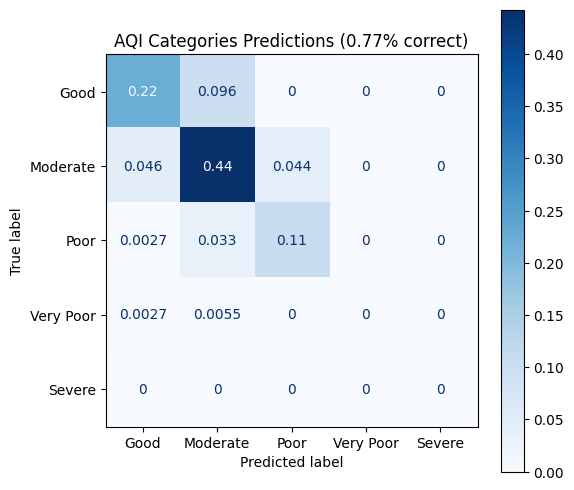

---------------------------------------------
> Absolute Mean AQI Difference: 11.92
> Positive Average AQI Difference: 11.30
> Negative Average AQI Difference: -12.81
> Percentage of Positive Differences: 59.29%
> Percentage of Negative Differences: 40.71%
> Percentage of Agent Values:
   - Same agent: 87.43
   - Different agents: 12.57


In [11]:
compute_AQI_and_show_analysis(agents_predictions_informative_original_dist, test_sets_informative_original_dist)

In 4 out of the 6 stations, the average error decreases, gaining 1-2% points in accuracy.

This is not an outstanding result, but we were able to reduce the model inputs to only 10 features while also achieving the same level of accuracy.